In [ ]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
from zipfile import ZipFile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
zip = ZipFile('/content/drive/My Drive/datasets/predict_sales_month/sales_train.csv.zip')

# p = 0.01
# with zip.open('sales_train.csv', 'r') as z:
#   df = pd.read_csv(z, skiprows= lambda x: x>0 and random.random() > p)

with zip.open('sales_train.csv', 'r') as z:
  df = pd.read_csv(z)

zip = ZipFile('/content/drive/My Drive/datasets/predict_sales_month/items.csv.zip')

with zip.open('items.csv', 'r') as z:
  df_item = pd.read_csv(z)

df_cat = pd.read_csv('/content/drive/My Drive/datasets/predict_sales_month/item_categories.csv')
df_shop = pd.read_csv('/content/drive/My Drive/datasets/predict_sales_month/shops.csv')

zip_test = ZipFile('/content/drive/My Drive/datasets/predict_sales_month/test.csv.zip')

with zip_test.open('test.csv') as zip_t:
  df_test = pd.read_csv(zip_t)

In [ ]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [ ]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [ ]:
df.drop('date', axis=1, inplace=True)

In [ ]:
df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'], dtype='object')

In [ ]:
for n in ['date_block_num', 'shop_id']:
  df[n] = df[n].astype(np.int8)
df['item_id'] = df['item_id'].astype(np.int16)
df['item_price'] = df['item_price'].astype(np.float32)
df['item_cnt_day'] = df['item_cnt_day'].astype(np.int16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int8   
 1   shop_id         int8   
 2   item_id         int16  
 3   item_price      float32
 4   item_cnt_day    int16  
dtypes: float32(1), int16(2), int8(2)
memory usage: 28.0 MB


In [ ]:
df.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,59,22154,999.000000,1
1,0,25,2552,899.000000,1
2,0,25,2552,899.000000,-1
3,0,25,2554,1709.050049,1
4,0,25,2555,1099.000000,1


Exploring df

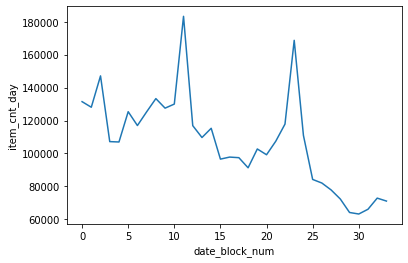

In [ ]:
data = df.groupby('date_block_num').agg({'item_cnt_day':'sum'}).reset_index()

sns.lineplot(
    x = 'date_block_num', y= 'item_cnt_day', data=data

)

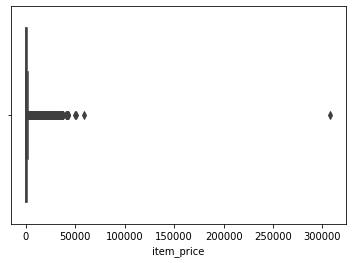

In [ ]:
sns.boxplot(df['item_price'])

In [ ]:
df = df[df['item_price']<200000]

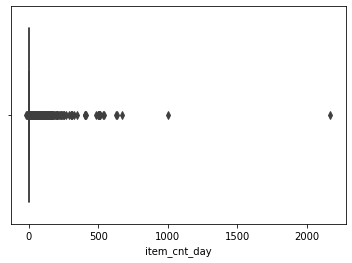

In [ ]:
sns.boxplot(df['item_cnt_day'])

In [ ]:
df = df[df['item_cnt_day']<1000]

In [ ]:
df = df[df['item_price']>0]
df = df[df['item_cnt_day']>0]

Id fixes

In [ ]:
df.loc[df.shop_id == 0, 'shop_id'] = 57
df_test.loc[df_test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
df.loc[df.shop_id == 1, 'shop_id'] = 58
df_test.loc[df_test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
df.loc[df.shop_id == 10, 'shop_id'] = 11
df_test.loc[df_test.shop_id == 10, 'shop_id'] = 11

Combine all the days into cnt month

In [ ]:
ls = df.groupby(['date_block_num','shop_id', 'item_id']).agg({'item_cnt_day':'sum'})
ls.columns = ['item_cnt_month']
ls.reset_index(inplace=True)

In [ ]:
df = pd.merge(df, ls, how='left', on=['date_block_num','shop_id', 'item_id'])

In [ ]:
df.drop('item_cnt_day', axis=1, inplace=True)

Making the matrix

In [ ]:
cols = ['date_block_num', 'shop_id', 'item_id']

In [ ]:
cols = ['date_block_num', 'shop_id', 'item_id']
mat =[]

for n in range(0,34):
  df_v1 = df[df.date_block_num == n]
  df_v = df_v1.copy()
  mat.append(np.array(list(product([n], df_v.shop_id.unique(), df_v.item_id.unique())), dtype = np.int16))

mat = pd.DataFrame(np.vstack(mat), columns=cols)


In [ ]:
mat.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [ ]:
mat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10884508 entries, 0 to 10884507
Data columns (total 3 columns):
 #   Column          Dtype
---  ------          -----
 0   date_block_num  int16
 1   shop_id         int16
 2   item_id         int16
dtypes: int16(3)
memory usage: 62.3 MB


Concat df_test

In [ ]:
df_test.drop('ID', axis=1, inplace=True)
df_test['date_block_num'] = 34
mat = pd.concat([mat, df_test], ignore_index=True, sort=False, keys=cols)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d893026d8>]],
      dtype=object)

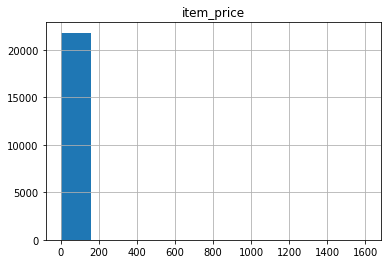

In [ ]:
df.groupby('item_id').agg({'item_price':'nunique'}).hist()

In [ ]:
df.groupby('item_id').agg({'item_price':'nunique'}).sort_values(by='item_price', ascending=False).head(10)

,item_price
item_id,
17717,1601
11373,426
11369,344
11370,335
6675,217
3732,215
11365,207
3731,198
1855,182


Prices are everywhere for several items, using a mean to map the prices at month 34

In [ ]:
ls = df.groupby('item_id').agg({'item_price':'mean'}).sort_values(by='item_price', ascending=False)
ls.columns = ['item_price']
ls.reset_index(inplace=True)
ls['date_block_num'] = 34

mat = pd.merge(mat, ls, how='left', on =['item_id', 'date_block_num'])

In [ ]:
mat = pd.merge(mat, df, how='left', on =cols)

In [ ]:
mat['item_price'] = mat['item_price_x'].combine_first(mat['item_price_y'])
mat.drop(['item_price_x','item_price_y'], axis=1, inplace=True)

In [ ]:
mat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12418973 entries, 0 to 12418972
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int64  
 1   shop_id         int64  
 2   item_id         int64  
 3   item_cnt_month  float64
 4   item_price      float32
dtypes: float32(1), float64(1), int64(3)
memory usage: 521.1 MB


In [ ]:
mat.describe()

,date_block_num,shop_id,item_id,item_cnt_month,item_price
count,1.241897e+07,1.241897e+07,1.241897e+07,2.928489e+06,3.127443e+06
mean,1.523615e+01,3.164199e+01,1.112478e+04,7.405118e+00,8.981953e+02
std,9.706114e+00,1.715907e+01,6.250750e+03,2.981560e+01,1.730853e+03
min,0.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,7.000000e-02
25%,7.000000e+00,1.700000e+01,5.630000e+03,1.000000e+00,2.490000e+02
50%,1.500000e+01,3.100000e+01,1.116200e+04,2.000000e+00,3.990000e+02
75%,2.300000e+01,4.700000e+01,1.646700e+04,5.000000e+00,9.990000e+02
max,3.400000e+01,5.900000e+01,2.216900e+04,1.644000e+03,5.920000e+04


Expand Cat

In [ ]:
df_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
df_cat['cat_type']=df_cat['item_category_name'].apply(lambda x: x.split('-')[0].strip())
df_cat['sub_cat_type']=df_cat['item_category_name'].apply(lambda x: x.split('-')[-1].strip())

df_cat['cat_type']= LabelEncoder().fit_transform(df_cat['cat_type'])
df_cat['sub_cat_type']= LabelEncoder().fit_transform(df_cat['sub_cat_type'])

In [ ]:
df_cat.drop('item_category_name', axis=1 , inplace=True)

Exapnd shop
\
city first head

In [ ]:
df_shop.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
df_shop['city_id'] = df_shop['shop_name'].apply(lambda x: x.split()[0])
df_shop['city_id'] = LabelEncoder().fit_transform(df_shop['city_id'])

In [ ]:
df_shop.drop('shop_name', axis=1, inplace=True)

df_item

In [ ]:
df_item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
df_item.drop('item_name', axis=1, inplace=True)

Combine to df

In [ ]:
mat = pd.merge(mat, df_item, how='left', on=['item_id'])
mat = pd.merge(mat, df_cat, how='left', on=['item_category_id'])
mat = pd.merge(mat, df_shop, how='left', on=['shop_id'])

In [ ]:
mat['month'] = mat['date_block_num'] % 12
mat['month']=mat['month'].astype(np.int8)

In [ ]:
mat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12418973 entries, 0 to 12418972
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int64  
 1   shop_id           int64  
 2   item_id           int64  
 3   item_cnt_month    float64
 4   item_price        float32
 5   item_category_id  int64  
 6   cat_type          int64  
 7   sub_cat_type      int64  
 8   city_id           int64  
 9   month             int8   
dtypes: float32(1), float64(1), int64(7), int8(1)
memory usage: 912.0 MB


In [ ]:
mat.isnull().sum()

date_block_num            0
shop_id                   0
item_id                   0
item_cnt_month      9490484
item_price          9291530
item_category_id          0
cat_type                  0
sub_cat_type              0
city_id                   0
month                     0
dtype: int64

In [ ]:
mat.describe()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_category_id,cat_type,sub_cat_type,city_id,month
count,1.241897e+07,1.241897e+07,1.241897e+07,2.928489e+06,3.127443e+06,1.241897e+07,1.241897e+07,1.241897e+07,1.241897e+07,1.241897e+07
mean,1.523615e+01,3.164199e+01,1.112478e+04,7.405118e+00,8.981953e+02,4.422482e+01,1.089169e+01,2.072828e+01,1.641789e+01,5.281198e+00
std,9.706114e+00,1.715907e+01,6.250750e+03,2.981560e+01,1.730853e+03,1.558364e+01,2.987634e+00,2.068508e+01,7.960837e+00,3.443253e+00
min,0.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,7.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,7.000000e+00,1.700000e+01,5.630000e+03,1.000000e+00,2.490000e+02,3.700000e+01,1.100000e+01,3.000000e+00,1.200000e+01,2.000000e+00
50%,1.500000e+01,3.100000e+01,1.116200e+04,2.000000e+00,3.990000e+02,4.000000e+01,1.100000e+01,1.400000e+01,1.400000e+01,5.000000e+00
75%,2.300000e+01,4.700000e+01,1.646700e+04,5.000000e+00,9.990000e+02,5.500000e+01,1.300000e+01,3.700000e+01,2.300000e+01,8.000000e+00
max,3.400000e+01,5.900000e+01,2.216900e+04,1.644000e+03,5.920000e+04,8.300000e+01,1.900000e+01,6.600000e+01,3.100000e+01,1.100000e+01


In [ ]:
mat.describe()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_category_id,cat_type,sub_cat_type,city_id,month
count,1.241897e+07,1.241897e+07,1.241897e+07,1.241897e+07,3.127443e+06,1.241897e+07,1.241897e+07,1.241897e+07,1.241897e+07,1.241897e+07
mean,1.523615e+01,3.164199e+01,1.112478e+04,1.746184e+00,8.981953e+02,4.422482e+01,1.089169e+01,2.072828e+01,1.641789e+01,5.281198e+00
std,9.706114e+00,1.715907e+01,6.250750e+03,1.481578e+01,1.730853e+03,1.558364e+01,2.987634e+00,2.068508e+01,7.960837e+00,3.443253e+00
min,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,7.000000e+00,1.700000e+01,5.630000e+03,0.000000e+00,2.490000e+02,3.700000e+01,1.100000e+01,3.000000e+00,1.200000e+01,2.000000e+00
50%,1.500000e+01,3.100000e+01,1.116200e+04,0.000000e+00,3.990000e+02,4.000000e+01,1.100000e+01,1.400000e+01,1.400000e+01,5.000000e+00
75%,2.300000e+01,4.700000e+01,1.646700e+04,0.000000e+00,9.990000e+02,5.500000e+01,1.300000e+01,3.700000e+01,2.300000e+01,8.000000e+00
max,3.400000e+01,5.900000e+01,2.216900e+04,1.644000e+03,5.920000e+04,8.300000e+01,1.900000e+01,6.600000e+01,3.100000e+01,1.100000e+01


In [ ]:
mat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12418973 entries, 0 to 12418972
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int64  
 1   shop_id           int64  
 2   item_id           int64  
 3   item_cnt_month    float64
 4   item_price        float32
 5   item_category_id  int64  
 6   cat_type          int64  
 7   sub_cat_type      int64  
 8   city_id           int64  
 9   month             int8   
dtypes: float32(1), float64(1), int64(7), int8(1)
memory usage: 912.0 MB


In [ ]:
ls = mat.describe().loc['max']
int_c = list(ls[ls<132].index)

for n in int_c:
  mat[n]= mat[n].astype(np.int8)

mat['item_cnt_month'].fillna(0, inplace=True)
mat['item_cnt_month'] = mat['item_cnt_month'].astype(np.int16)
mat['item_id'] = mat['item_id'].astype(np.int16)

In [ ]:
mat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12418973 entries, 0 to 12418972
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int8   
 1   shop_id           int8   
 2   item_id           int16  
 3   item_cnt_month    int16  
 4   item_price        float32
 5   item_category_id  int8   
 6   cat_type          int8   
 7   sub_cat_type      int8   
 8   city_id           int8   
 9   month             int8   
dtypes: float32(1), int16(2), int8(7)
memory usage: 272.4 MB


In [ ]:
mat.to_pickle('/content/drive/My Drive/datasets/predict_sales_month/final_mat_1.pkl')